# CZSa 2024 Homework 1

## Instructions

You are allowed to collaborate and to use information from slides, books, internet etc., for solving this homework. HOWEVER, in the final exam, there will be some questions that are very similar to some questions of this homework and/or the next homework. These questions can give ten (10) points in total on the exam. Therefore, it is beneficial for you to understand the answers you provide here.

Deadline 2024-12-16 by email. Please include any code you have written either, separately or as verbatim text in the report. 

Please don't hestitate to ask if something is unclear.

## 1 (3p)
### a) 
Calculate numerically the SNR resulting from quantization of a real signal. For example, you can use the speech recording ```00011.wav``` available in the GitHub repository. Plot the SNR vs the number of bits, e.g., for $\# \rm{bit}s=2,3,4,5,6,7,8$. \
You can use the functions ```quantize```, ```normalize``` and other code pieces from Exercise 1. 

In [8]:
# Libraries and reading the audio file
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from IPython.display import Audio

audio_file = "00011.wav"
r, a = scipy.io.wavfile.read(audio_file)
a = a.astype("int32")  
# Note that this means we are using 32bit quantization. 
# The original quantization was 16 so we can't get better than that actually (worth keeping in mind in the below experiments).

In [6]:
# Quantization function
def quantize(x, b=4, level_at_zero=False):
    """
    x:             The signal. Assumed to be in the range -1 to 1
    b:             Number of bits. The number of quantization levels is 2^b
    level_at_zero: If True, the first quantization level will be at
                    -1 and the last at -q where q is the quantization step.
                    This means there will be a quantization level in 0.
                    This is the "Q" format standard.
                    If False, the first level will be at -1+q/2 and the
                    last at 1-q/2. This is symmetric.
                    Plot and see the difference if unclear.
    """
    n = 2**b # Number of quantization leveles
    r = 2    # range, i.e. 2 times amplitude

    if level_at_zero:
        o=0
    else:
        o = r/(2*n)

    ql = np.linspace(-1 +o, 1-2/n +o  ,n)
    xq = list(map(lambda v: ql[np.argmin(np.abs(v-ql))], x))

    return xq

# Returns the input normalized so that is in [0,1]
def normalize(x):
    return 2*(x - np.min(x)) / (np.max(x) - np.min(x))-1, np.max(x),  np.min(x)

# Sets it back to its original range
def de_normalize(x, ma, mi):
    return (x + 1)*(ma-mi)/2 + mi

# Calculating the SNR
def calculate_snr(original_signal, quantized_signal):
    # Power of the original signal
    signal_power = np.mean(original_signal**2)
    
    # Power of the noise (quantization error)
    noise_power = np.mean((original_signal - quantized_signal)**2)
    
    # Calculate SNR in decibels
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

Why calculating power is sufficient in this case: In the discrete case, when the signal is finite in length, calculating the sum of squared values (energy) is equivalent to computing the mean (power) if you are comparing over the same interval. Both methods provide a valid SNR. In fact, when comparing two signals over the same number of samples, the relative ratio of their energies is the same as the ratio of their powers.

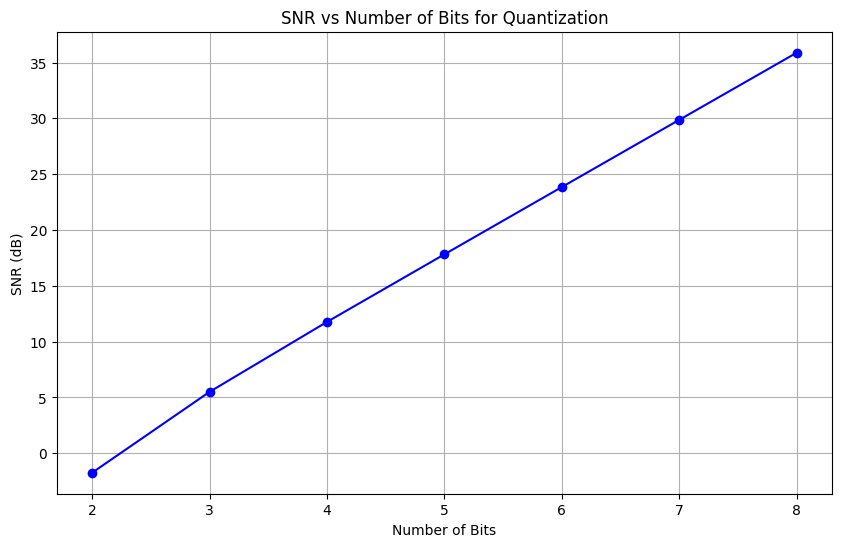

In [11]:
# Bit depths from 2 to 8
bits = np.arange(2, 9)
snr_values = []

# Normalize the signal
a_normalized, ma, mi = normalize(a)

for b in bits:
    # Quantize the normalized signal
    a_quantized = np.array(quantize(a_normalized, b))
    
    # Calculate SNR for the current quantization
    snr = calculate_snr(a_normalized, a_quantized)
    snr_values.append(snr)

# Plotting SNR vs Number of Bits
plt.figure(figsize=(10, 6))
plt.plot(bits, snr_values, marker='o', linestyle='-', color='b')
plt.title('SNR vs Number of Bits for Quantization')
plt.xlabel('Number of Bits')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.show()

As the number of bits used for quantization increases, the SNR (Signal-to-Noise Ratio) increases because quantization error (or noise) decreases. 

Intuition: More bits → More levels → Smaller quantization steps → Smaller quantization error → Higher SNR.

In [16]:
# Demo of various quantization levels
for b in bits:
   a_quantized = np.array(quantize(a_normalized, b))
   display(Audio(quantize(a_normalized, b), rate=16000))

### b) 
Compare the plot to the two results for SNR we derived in Lecture 1, i.e., 
\begin{equation}
SNR_{\rm{sine}}=6.02b + 1.67\,\,dB
\end{equation}
and
\begin{equation}
SNR_{\rm{uniform}}=6.02b\,\,dB
\end{equation}
where $SNR_{\rm{sine}}$ and $SNR_{\rm{uniform}}$ refers to the case of a sine signal and a uniformly distributed signal respectively (one example of a uniformly distributed signal is the sawtooth signal [https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sawtooth.html)). In both formulas, $b$ is the number of bits used for the quantization. For both formulas, the error is assumed to be uniformly distributed in $[-q/2, q/2]$ where $q$ is the quantiztion step, i.e., the difference of two adjecent quantiztion levels. 

### c)
Analyse how accurate the assumptions for the above two formulas are for the signal you used. The assumptions about uniform distributions can be analaysed for example by plotting histograms. The assumptions about the signal being a pure sine or cosine signal can be checked by calculating DFT and plotting the spectrum.  

## 2 (2p)
Recall from Lecture 1 that if a signal is sampled with sampling frequency $F_s$ and before sampling contained only frequencies below $F_s/2$ then it can be reconstructed according to
\begin{equation}
f(t)=\sum_{n=-\infty}^{\infty} f\left(\frac{n}{F_s} \right )\frac{\sin(tF_s\pi -n\pi)}{tF_s\pi -n\pi}\quad (1),
\end{equation}
where $f\left(\frac{n}{F_s} \right )= f\left(nT_s \right )$ is the signal values at the sampling points ($F_s=1/T_s$).
### a)
Downsample (decimate) the signal used before with a factor 4 using the appropriate anti-aliasing filter. That is, if your original signal is in 16KHz (and accordingly has already been filtered so that it only contains frequencies below 8KHz) you

1. Create a low pass filter with cut off frequency 2KHz (you can use code snippets from exercise 4 based on ```scicpy.signal``` for this) and send the signal through the filter. Denote the obtained signal $x[n]$.
2. Discard 3 out of four samples, i.e., you keep every fourth sample of the signal. This can be written as $x_{\rm{d}}[n]=x[4n]$ where the left hand side is the downsampled signal and the right hand side is the original signal after anti-alias filtering. 

### b)
Use Equation (1) above to reconstruct some values of the original signal, $x[n]$, that are not part of $x_{\rm{d}}[n]$, e.g. $x[4n+2]$. Of of course, you need to replace the infinite limits in the sum with finite ones. It is a good idea to take equally many on each side of the point of interest. Try briefly how many you seem to need for accurate results. You don't need to analyse this deeply. 
Compare the result to the correct values as well as the ones obtained by simple linear interpolation of the two surrounding points, i.e., 
\begin{equation}
\frac{x_{\rm{d}}[n] + x_{\rm{d}}[n+1]}{2}=\frac{x[4n] + x[4(n+1)]}{2}
\end{equation}.

## 3 (2p)
Show that a symmetric FIR filter with with odd number of real coefficients has linear phase. Here, antisymmetric means the filter coefficients fulfill 
\begin{equation}
h[N-n]=h[N+n]
\end{equation}
where $N$ and $n$ are postitive integers, $n\leq N$ and the filter has length $2N+1$. (See slides of lecture 4 for a figure.)